In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikit-plot --quiet
!pip install scikit-optimize --quiet
!pip install keras-tuner --upgrade --quiet

In [24]:
import pandas as pd
import numpy as np
import os
import sys
import inspect

# DateTime
import datetime
from datetime import date, timedelta, datetime

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scikitplot as skplt

# Hierarchical Clustering
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Model and Evaluation
from sklearn import metrics
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Stats
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import randint as sp_randint

# SMOTE for Imbalance
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Neuronet
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

# Keras Tuner
import keras_tuner as kt
from tensorflow.keras.layers import  LeakyReLU, ELU
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad
from tensorflow.keras.activations import relu, sigmoid

# Re-Utilise the model
import pickle
from tensorflow.keras.models import load_model
from joblib import dump, load


To address the complexities of pinpointing key traits within the target RFM cluster, we adopted a structured approach using machine learning techniques to uncover and categorize the inherent groupings.

In [4]:
Customer_segment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/Customer_segment.csv', index_col=1)
Customer_segment.info()
display(Customer_segment)

# Inspect the cluster group from transaction dataset from previous task
fig = px.scatter_3d(Customer_segment, x='transaction_count', y='most_recent_transaction_day', z='sum_profit', opacity=0.7, color='label')
#fig1.update_layout(coloraxis=dict(colorbar=dict(len=1)))
fig.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig.show()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 2950 to 3168
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           2446 non-null   int64  
 1   transaction_count                    2446 non-null   int64  
 2   most_recent_transaction_day          2446 non-null   int64  
 3   sum_profit                           2446 non-null   float64
 4   age                                  2446 non-null   float64
 5   gender                               2446 non-null   object 
 6   wealth_segment                       2446 non-null   object 
 7   state                                2446 non-null   object 
 8   job_title                            2446 non-null   object 
 9   job_industry_category                2446 non-null   object 
 10  owns_car                             2446 non-null   bool   
 11  past_3_years_bike_related_p

,Unnamed: 0,transaction_count,most_recent_transaction_day,sum_profit,age,gender,wealth_segment,state,job_title,job_industry_category,owns_car,past_3_years_bike_related_purchases,tenure,property_valuation,label,job_cluster
customer_id,,,,,,,,,,,,,,,,
2950,0,3,2229,645.99,68.0,Male,Mass Customer,VIC,Software Engineer I,Financial Services,True,19.0,10.0,6.0,1,6.0
3120,3,7,2174,4179.11,44.0,Female,Mass Customer,NSW,Clinical Specialist,Health,True,89.0,10.0,5.0,2,3.0
402,10,6,2210,4965.43,46.0,Male,Affluent Customer,NSW,Desktop Support Technician,Retail,False,9.0,22.0,1.0,2,0.0
3135,16,7,2275,3983.97,61.0,Male,Mass Customer,NSW,Staff Scientist,Financial Services,False,83.0,16.0,10.0,2,14.0
2339,23,8,2165,3960.56,64.0,Male,Affluent Customer,NSW,Web Designer II,Property,True,3.0,16.0,10.0,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,13616,2,2201,1168.94,48.0,Male,Mass Customer,VIC,Food Chemist,Health,True,17.0,17.0,4.0,1,0.0
130,13618,2,2230,1779.58,26.0,Male,Mass Customer,NSW,Chemical Engineer,Manufacturing,False,32.0,1.0,7.0,1,2.0
2789,13620,2,2178,549.09,30.0,Female,Affluent Customer,NSW,Senior Editor,Financial Services,True,66.0,7.0,11.0,1,34.0


# 1.0 Feature Engineering and Preprocessing


In [5]:
# Feature encoding before feeding the classification model -------------------------------
df = Customer_segment.copy()
df.drop(['Unnamed: 0','job_title'], axis=1, inplace=True)
df = df.drop(['transaction_count', 'most_recent_transaction_day', 'sum_profit'], axis=1)
# Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[['Mass Customer', 'High Net Worth', 'Affluent Customer']])
df['wealth_segment'] = ordinal_encoder.fit_transform(df[['wealth_segment']])
# Dummies
categorical_cols = ['gender', 'state','job_industry_category', 'owns_car','job_cluster']
df = pd.get_dummies(df, columns=categorical_cols)
# Combine age and tenure feature by adding the log-transformed
Log_age = np.log(df['age'] + 1)
Log_tenure = np.log(df['tenure'] + 1)
df['Log_age_tenure'] = Log_age + Log_tenure
df = df.drop(['age', 'tenure'], axis=1)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 2950 to 3168
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   wealth_segment                            2446 non-null   float64
 1   past_3_years_bike_related_purchases       2446 non-null   float64
 2   property_valuation                        2446 non-null   float64
 3   label                                     2446 non-null   int64  
 4   gender_Female                             2446 non-null   uint8  
 5   gender_Male                               2446 non-null   uint8  
 6   state_NSW                                 2446 non-null   uint8  
 7   state_QLD                                 2446 non-null   uint8  
 8   state_VIC                                 2446 non-null   uint8  
 9   job_industry_category_Argiculture         2446 non-null   uint8  
 10  job_industry_category_Entertainme

,wealth_segment,past_3_years_bike_related_purchases,property_valuation,label,gender_Female,gender_Male,state_NSW,state_QLD,state_VIC,job_industry_category_Argiculture,...,job_cluster_32.0,job_cluster_33.0,job_cluster_34.0,job_cluster_35.0,job_cluster_36.0,job_cluster_37.0,job_cluster_38.0,job_cluster_39.0,job_cluster_40.0,Log_age_tenure
customer_id,,,,,,,,,,,,,,,,,,,,,
2950,0.0,19.0,6.0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6.632002
3120,0.0,89.0,5.0,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.204558
402,2.0,9.0,1.0,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.985642
3135,0.0,83.0,10.0,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.960348
2339,2.0,3.0,10.0,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7.007601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,0.0,17.0,4.0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6.782192
130,0.0,32.0,7.0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.988984
2789,2.0,66.0,11.0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,5.513429


#2.0 Model Implementation
  - 1 Preprocess training dataset
    - Feature augmentation dealing with imbalance class
    - Feature Scaling
  - 2 Model Pipline and Evaluation
    - 2.1 Baseline Model: Multiclassification Identification Model
    - 3.2 Two-Step Model Strategy Implementation
      - Model 1: Inactive Customer Identification Model
      - Model 2: High-Value Customer Identification

2.1 Preprocess Training Dataset

In [20]:
# Import ModelClassification fuction
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts')
# For Preprocessing
from ModelClassification import preprocess_trainingdata, set_seed
print(inspect.getsource(preprocess_trainingdata))
print(inspect.getsource(set_seed))

def preprocess_trainingdata(df, label_column, test_size=0.2, random_state=42):
    """
    Preprocess the data: split, balance class, scale, and encode the labels.

    Parameters:
    df (DataFrame): The dataframe containing the features and labels.
    label_column (str): The name of the column containing the labels.
    test_size (float): The size of the test set. Default is 0.2.
    random_state (int): The seed used by the random number generator.

    Returns:
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes
    """

    # Splitting the data
    X = df.drop([label_column], axis=1)
    y = df[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Visualizing class balance
    visualizer = ClassBalance()
    visualizer.fit(y_train, y_test)
    visualizer.show()

    # Balancing the classes with SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resampl

##2.1 Baseline Model: Multiclassification Identification Model
- Problem Definition:Using multi-classification as a Baseline model to classify and retreive the customers into 3 groups
  - 0: non-active customer
  - 1: low/med-value customer
  - 2: high-value customer

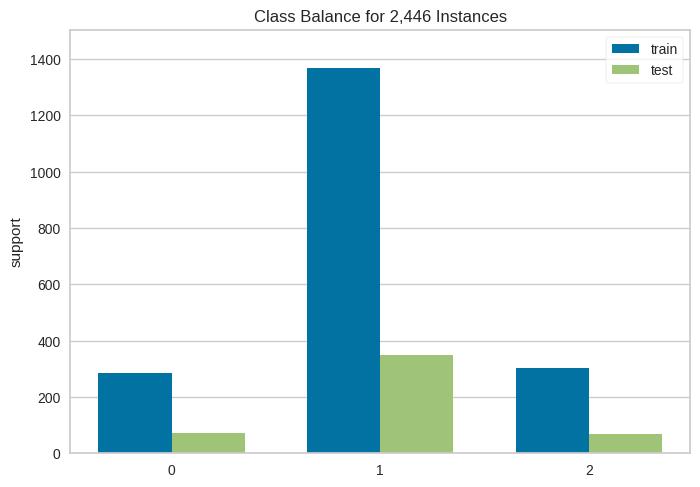

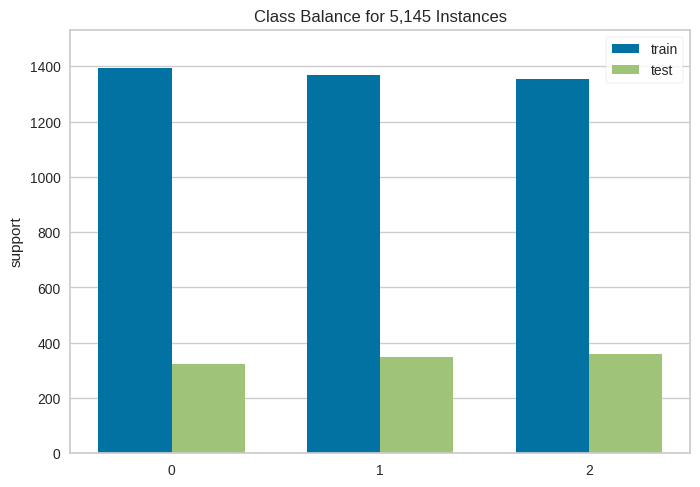

In [9]:
# M0.1_Problem Definition: ----------------------------------------------------
# Using multi-classification as a Baseline model to classify and retreive the customers into 3 groups
  # 0: non-active customer
  # 1: low/med-value customer
  # 2: high-value customer
df0 = df.copy()
df0['label'].replace(to_replace=[0.0, 1.0, 2.0, 3.0],
           value= ['0', '1', '1', '2'],
           inplace=True)

# M0.2_Preprocessing training dataset -------------------------------------
# Call function for preprocessing training data: By split, balance class, scale, and encode the labels.
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes, label_encoder = preprocess_trainingdata(df0, label_column = 'label', test_size=0.2, random_state=42)

# Convert integer labels to one-hot encoding for multi-classification task
y_train_onehot = to_categorical(y_train_encoded, num_classes=n_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=n_classes)

In [ ]:
# M0.3_Model architecture ------------------------------------------
# building based on the best parameter found on Keras-tunner
model0 = Sequential()
model0.add(Dense(64, activation='relu', input_shape=(n_features,), kernel_regularizer=regularizers.l2(0.01)))
model0.add(Dropout(0.5))
model0.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model0.add(Dropout(0.75))
model0.add(Dense(n_classes, activation='softmax'))

# Compile the model
learning_rate = 0.005  # Adjusted learning rate for stability
adam_optimizer = Adam(learning_rate=learning_rate)
sgd= SGD(learning_rate=learning_rate)
model0.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Define the class weights
class_weights = {0:1, 1:1, 2:1}  # Adjust the weights according to the result

# Train the model with the new callback/ class weights
history0 = model0.fit(X_train_scaled, y_train_onehot, validation_split=0.2, epochs=500, batch_size=32,
                    callbacks=[es],class_weight=class_weights)

# Save model and training history
model0.save('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model0.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model0_history.pkl', 'wb') as file:
    pickle.dump(history0, file)

Epoch 1/500
70/70 [==============================] - 2s 11ms/step - loss: 2.7374 - accuracy: 0.3171 - val_loss: 2.1224 - val_accuracy: 0.3679
Epoch 2/500
70/70 [==============================] - 0s 5ms/step - loss: 2.4954 - accuracy: 0.3278 - val_loss: 2.0810 - val_accuracy: 0.3929
Epoch 3/500
70/70 [==============================] - 0s 3ms/step - loss: 2.3434 - accuracy: 0.3453 - val_loss: 2.0564 - val_accuracy: 0.4446
Epoch 4/500
70/70 [==============================] - 0s 4ms/step - loss: 2.2361 - accuracy: 0.3502 - val_loss: 2.0366 - val_accuracy: 0.4536
Epoch 5/500
70/70 [==============================] - 0s 3ms/step - loss: 2.1715 - accuracy: 0.3502 - val_loss: 2.0186 - val_accuracy: 0.4643
Epoch 6/500
70/70 [==============================] - 0s 3ms/step - loss: 2.1200 - accuracy: 0.3739 - val_loss: 2.0028 - val_accuracy: 0.4804
Epoch 7/500
70/70 [==============================] - 0s 3ms/step - loss: 2.0858 - accuracy: 0.3623 - val_loss: 1.9887 - val_accuracy: 0.4750
Epoch 8/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [25]:
# Import ModelClassification fuction
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts')
# For Evaluation
from ModelClassification import evaluate_and_plot_model, display_classification_results, plot_multiclass_roc, plot_binaryclass_roc, plot_multiple_roc_curves
print(inspect.getsource(evaluate_and_plot_model))
print(inspect.getsource(display_classification_results))
print(inspect.getsource(plot_multiclass_roc))
print(inspect.getsource(plot_binaryclass_roc))
print(inspect.getsource(plot_multiple_roc_curves))

def evaluate_and_plot_model(model, X_test, y_test, history):
    """
    Evaluate the given model using the test data and plot the training
    and validation loss and accuracy from training's history
    """
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', score[1])

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def display_classification_results(y_test_encoded, y_pred, label_encoder):
    """
    Displays the class

Test accuracy: 0.5646258592605591


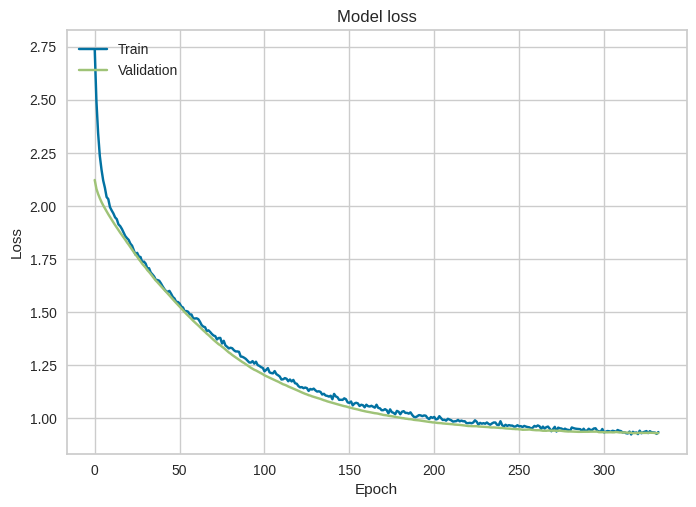

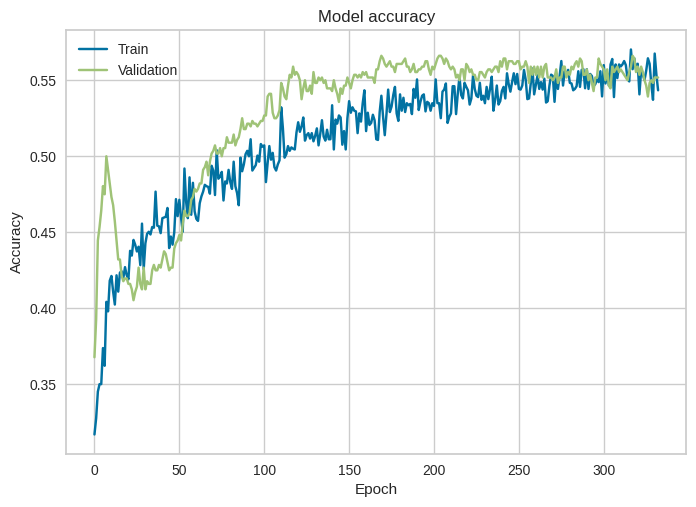

33/33 [==============================] - 0s 2ms/step
Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.70      0.55       322
           1       0.68      0.99      0.81       348
           2       0.43      0.03      0.06       359

    accuracy                           0.56      1029
   macro avg       0.52      0.57      0.47      1029
weighted avg       0.52      0.56      0.47      1029



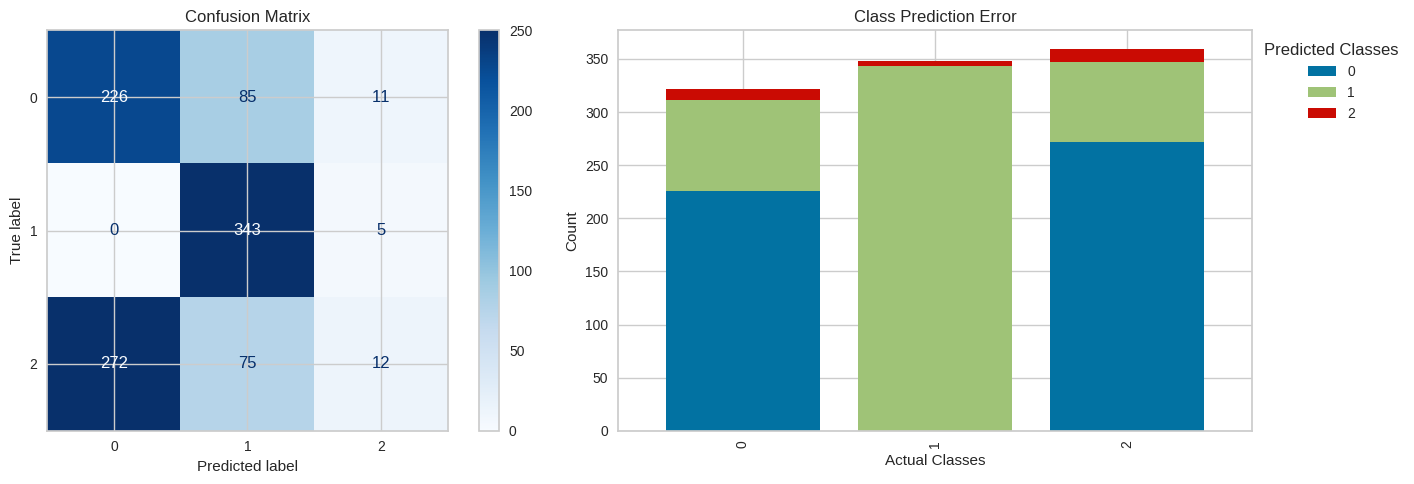

In [12]:
# M0.4_Model Evaluation ------------------------------------------
# Load the saved model
model0 = load_model('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model0.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model0_history.pkl', 'rb') as file:
    history0 = pickle.load(file)

# Call function for evaluating model training
evaluate_and_plot_model(model0, X_test_scaled, y_test_onehot, history0)

# Predict on the test set
y_pred_probs_0 = model0.predict(X_test_scaled)
y_pred_encoded = np.argmax(y_pred_probs_0, axis=1)  # Convert one-hot encoded predictions to integers
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_true = label_encoder.inverse_transform(y_test_encoded)

# Call funtion for classification report
display_classification_results(y_true, y_pred, label_encoder)

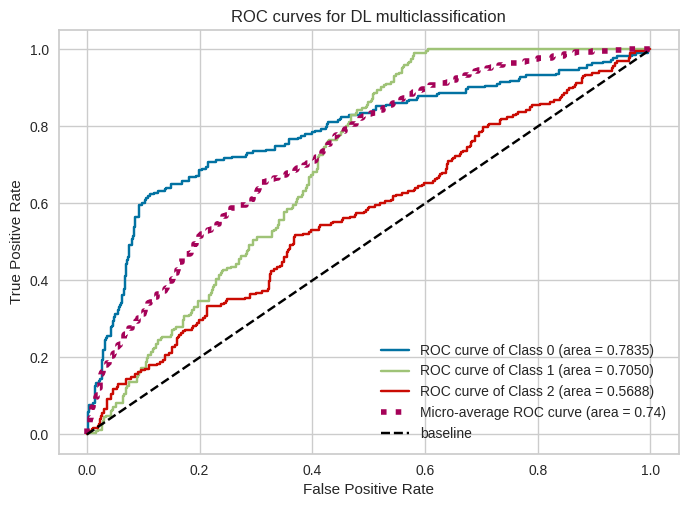

In [ ]:
plot_multiclass_roc(y_test_onehot, y_pred_probs_0, title='ROC curves for DL multiclassification')

##2.2 Two-Step Binary Classification Model

- Problem Definition: Instead of multi-classification task, we will breaking it down into two-step binary classification model, as there's a significant class imbalance or a lack of sufficient information in the dataset.


###2.2.1 Model 1: Non-active Customer Identification Model
  - identifies Non-active Customer (class 0) versus all others (class 1).

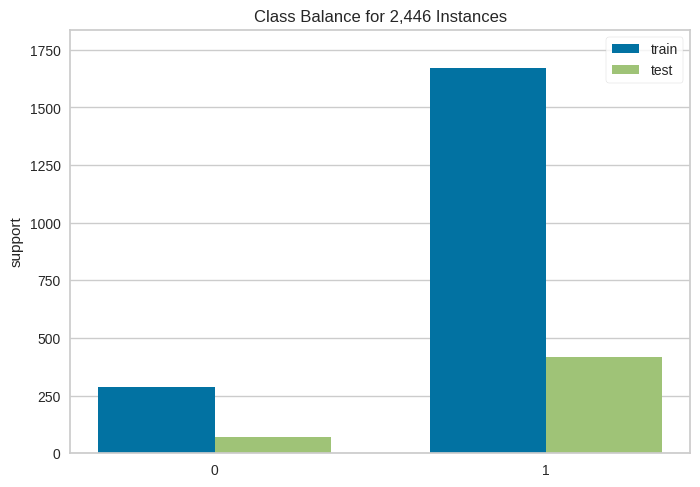

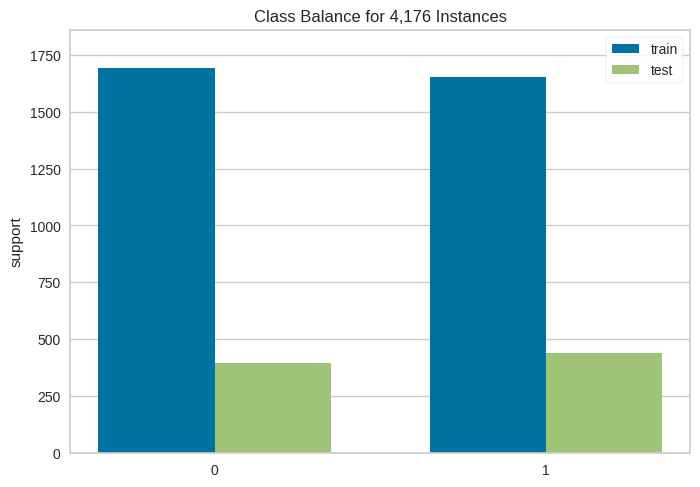

In [14]:
# Model 1: Non-active Customer Identification Model
df1 = df.copy()
df1['label'].replace(to_replace=[0.0, 1.0, 2.0, 3.0], # identifies Non-active Customer  (class 0) versus all others (class 1).
           value= ['0', '1', '1', '1'],
           inplace=True)

# 2_Preprocessing training dataset -------------------------------------
# Call function for preprocessing training data: By split, balance class, scale, and encode the labels.
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes, label_encoder = preprocess_trainingdata(df1, label_column = 'label', test_size=0.2, random_state=42)


In [ ]:
# 3_Model architecture ---------------------------------
model1 = Sequential()
model1.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.75))
model1.add(Dense(125, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.5))
model1.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))  # Only one neuron for binary classification

# Compile the model
learning_rate = 0.001  # Adjusted learning rate for stability
adam_optimizer = Adam(learning_rate=learning_rate)
model1.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Train the model with EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Define the class weights according to the result
class_weights = {0: 1,
                 1: 1.25}

# Train the model with the new callback/ class weights
history1 = model1.fit(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=500, batch_size=32,
                    callbacks=[es],
                    class_weight=class_weights)

# Save model and training history
model1.save('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model1.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model1_history.pkl', 'wb') as file:
    pickle.dump(history1, file)

Epoch 1/500
83/83 [==============================] - 3s 12ms/step - loss: 7.3103 - accuracy: 0.5211 - val_loss: 4.4992 - val_accuracy: 0.7319
Epoch 2/500
83/83 [==============================] - 1s 8ms/step - loss: 3.2540 - accuracy: 0.7278 - val_loss: 2.1866 - val_accuracy: 0.9021
Epoch 3/500
83/83 [==============================] - 0s 6ms/step - loss: 1.7701 - accuracy: 0.8548 - val_loss: 1.2866 - val_accuracy: 0.9111
Epoch 4/500
83/83 [==============================] - 0s 4ms/step - loss: 1.1624 - accuracy: 0.8767 - val_loss: 0.8917 - val_accuracy: 0.9127
Epoch 5/500
83/83 [==============================] - 0s 5ms/step - loss: 0.8617 - accuracy: 0.8801 - val_loss: 0.6827 - val_accuracy: 0.9157
Epoch 6/500
83/83 [==============================] - 0s 5ms/step - loss: 0.7076 - accuracy: 0.8857 - val_loss: 0.5711 - val_accuracy: 0.9157
Epoch 7/500
83/83 [==============================] - 0s 5ms/step - loss: 0.6290 - accuracy: 0.8835 - val_loss: 0.5066 - val_accuracy: 0.9172
Epoch 8/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



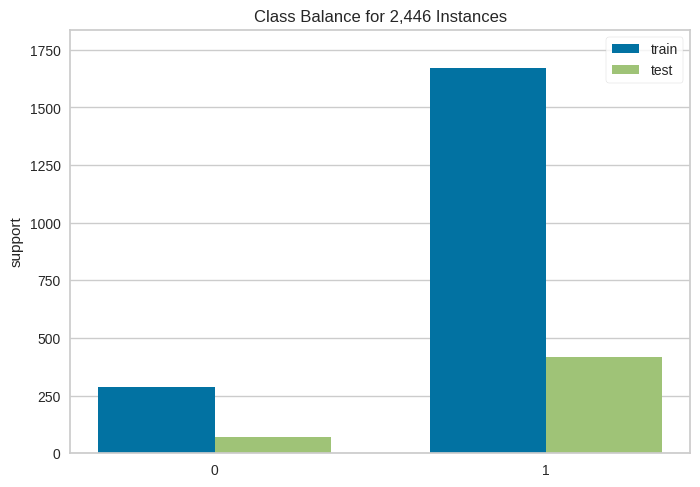

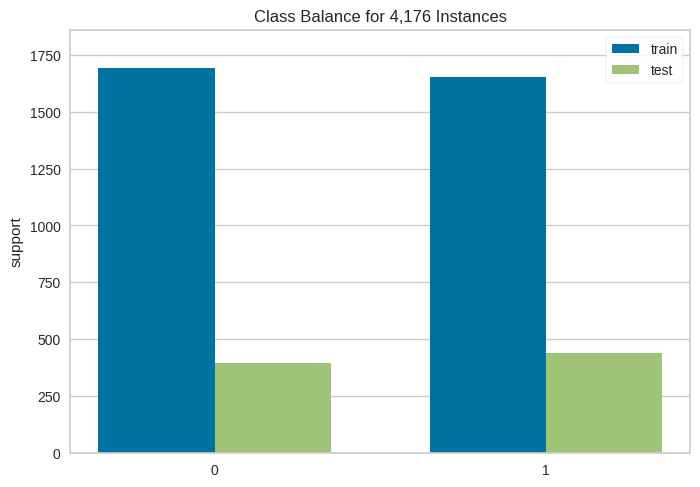

Test accuracy: 0.8959330320358276


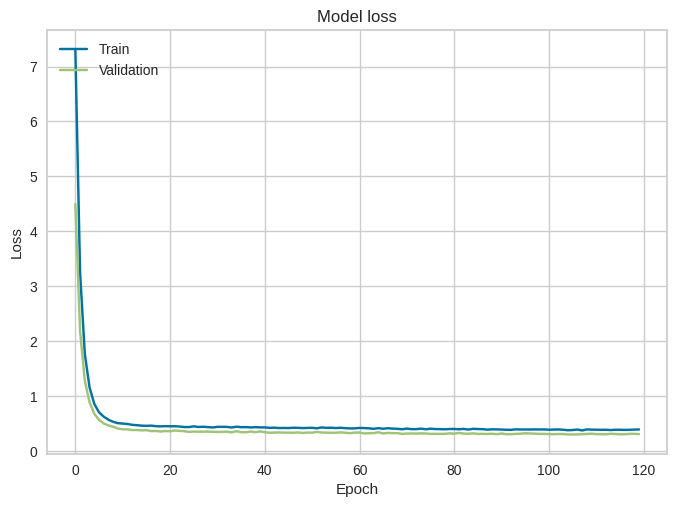

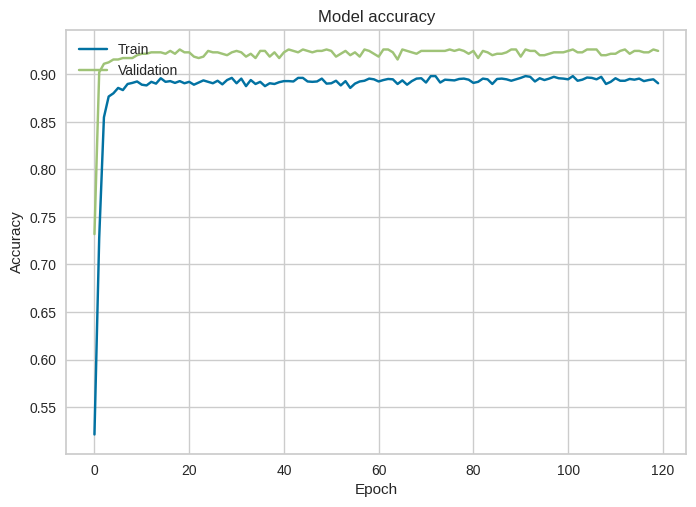

27/27 [==============================] - 0s 2ms/step
Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88       398
           1       0.83      1.00      0.91       438

    accuracy                           0.90       836
   macro avg       0.92      0.89      0.89       836
weighted avg       0.91      0.90      0.89       836



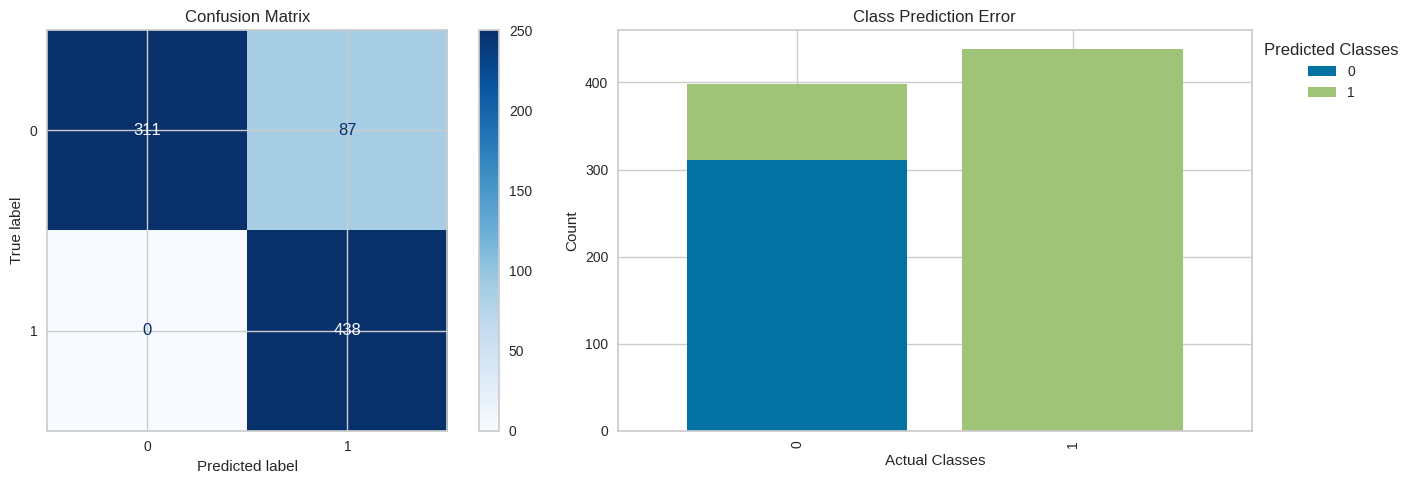

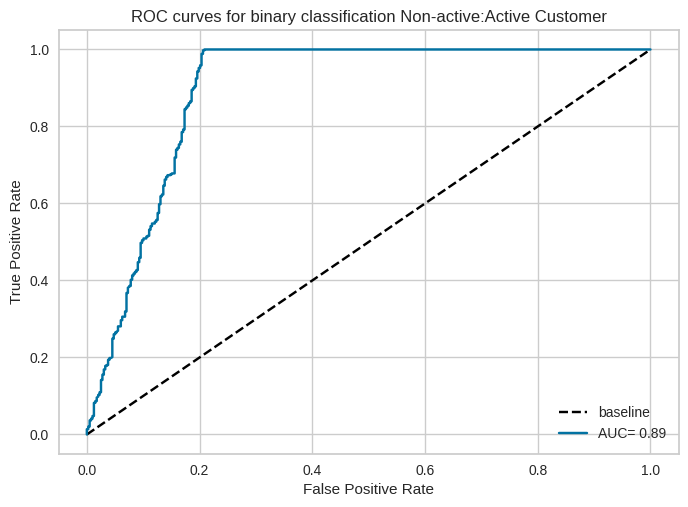

In [18]:
# 2_Preprocessing training dataset -------------------------------------
# Call function for preprocessing training data: By split, balance class, scale, and encode the labels.
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes, label_encoder = preprocess_trainingdata(df1, label_column = 'label', test_size=0.2, random_state=42)

# 4_Model Evaluation ------------------------------------------
# Load the saved model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model1.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model1_history.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Call function for evaluating model training
evaluate_and_plot_model(model1, X_test_scaled, y_test_encoded, history1)

# Predict on the test set and threshold probabilities
y_pred_prob_1 = model1.predict(X_test_scaled)
y_pred = (y_pred_prob_1 > 0.5
          ).astype(int)
y_pred = y_pred.ravel()

# Call funtion for classification report
display_classification_results(y_test_encoded, y_pred, label_encoder)
plot_binaryclass_roc(y_test_encoded, y_pred_prob_1, title='ROC curves for binary classification Non-active:Active Customer')

### Conclusion:
- Task: Multiclass classification to categorize
customers into including non-active (0)/ low /medium-value (1)/ high-value (2)
- Model: A neural network with automated hyperparameter tuning
- Evaluation: The model's performance, assessed through loss and accuracy on training and validation set
- Result: Imbalanced accuracy across classes, as indicated by the ROC/AUC curves and classification report. Overall 0.74 AUC with 0.55 accuracy score




###2.2.2 Model 2:  High-Value Customer Identification Model
- The resulted active customer from the first model are fed into the second training model to distinguish a level of customer value, so we filter out non-active customer and training to identify high/mid-value customer (class 1) vs low-value customer (class 0)


<ipython-input-19-998248b12e57>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



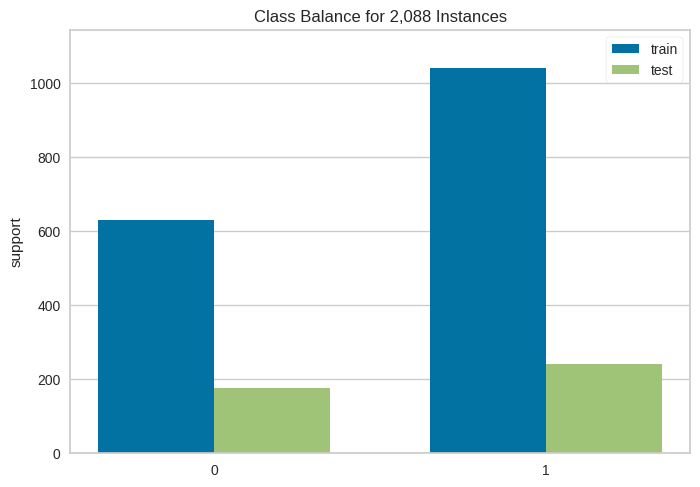

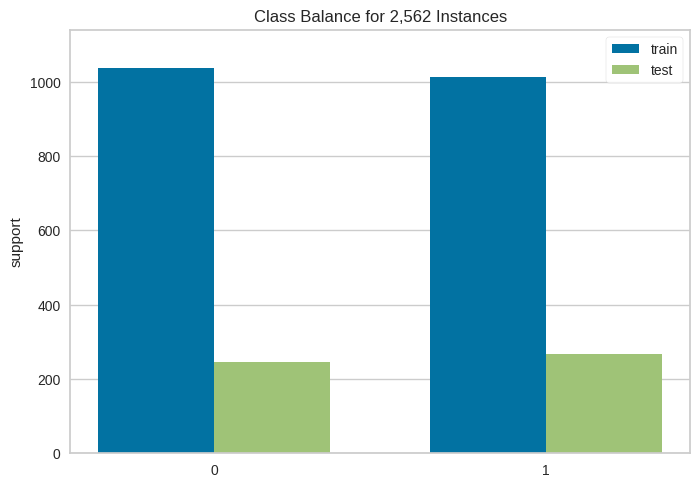

In [19]:
# 1_Problem Definition: ----------------------------------------------------
# Model 2: High-Value Customer Identification
df2 = df[df['label']!=0]
df2['label'].replace(to_replace=[1.0, 2.0, 3.0],
           value= ['0', '1', '1'],
           inplace=True)

# 2_Preprocessing training dataset -------------------------------------
# Call function for preprocessing training data: By split, balance class, scale, and encode the labels.
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes, label_encoder = preprocess_trainingdata(df2, label_column = 'label', test_size=0.2, random_state=42)

### - Deep Learning Model

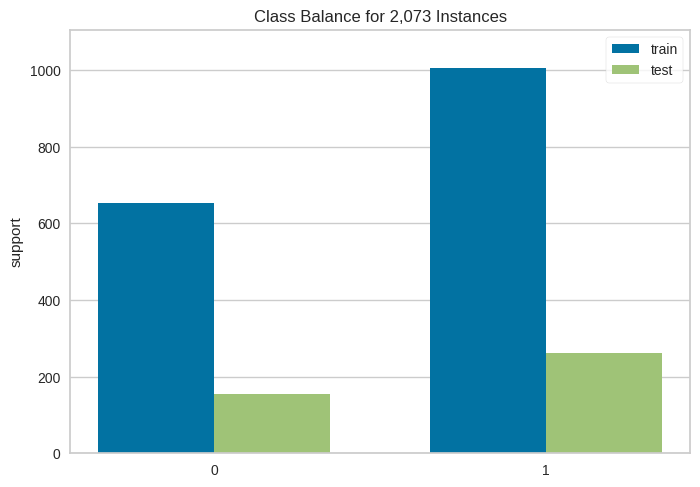

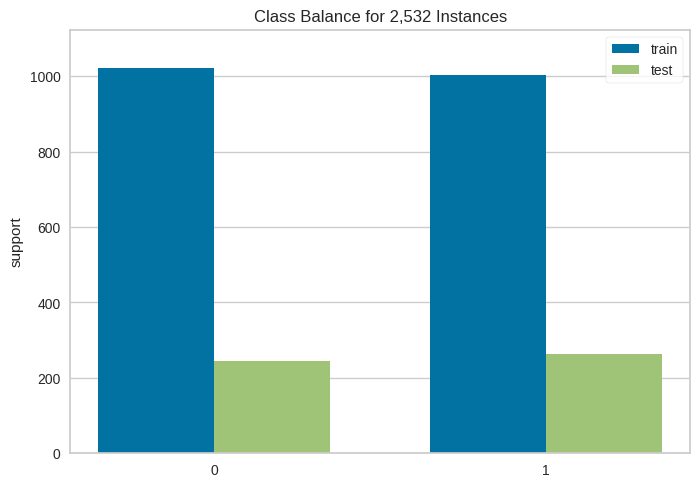

Epoch 1/500
26/26 [==============================] - 4s 36ms/step - loss: 9.0321 - accuracy: 0.5117 - val_loss: 7.6509 - val_accuracy: 0.5407
Epoch 2/500
26/26 [==============================] - 0s 10ms/step - loss: 7.0116 - accuracy: 0.5296 - val_loss: 5.9928 - val_accuracy: 0.5481
Epoch 3/500
26/26 [==============================] - 0s 7ms/step - loss: 5.4830 - accuracy: 0.5728 - val_loss: 4.7154 - val_accuracy: 0.5580
Epoch 4/500
26/26 [==============================] - 0s 10ms/step - loss: 4.3356 - accuracy: 0.5759 - val_loss: 3.7433 - val_accuracy: 0.5432
Epoch 5/500
26/26 [==============================] - 1s 42ms/step - loss: 3.4683 - accuracy: 0.5778 - val_loss: 3.0074 - val_accuracy: 0.5457
Epoch 6/500
26/26 [==============================] - 1s 32ms/step - loss: 2.8134 - accuracy: 0.5636 - val_loss: 2.4511 - val_accuracy: 0.5309
Epoch 7/500
26/26 [==============================] - 1s 31ms/step - loss: 2.3206 - accuracy: 0.5759 - val_loss: 2.0349 - val_accuracy: 0.5333
Epoch 8

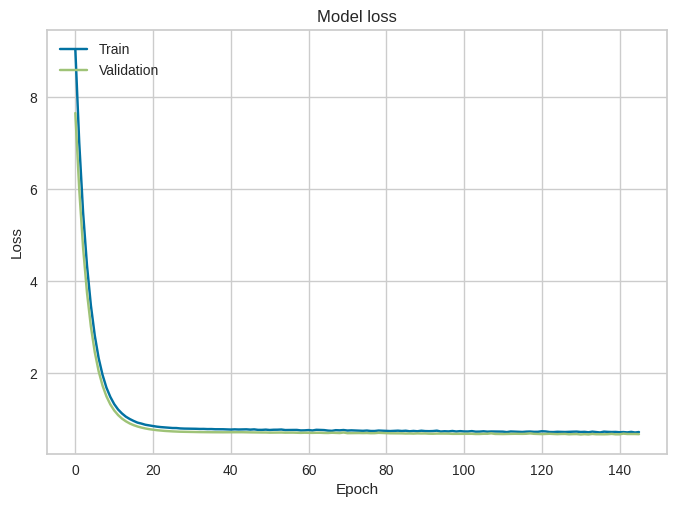

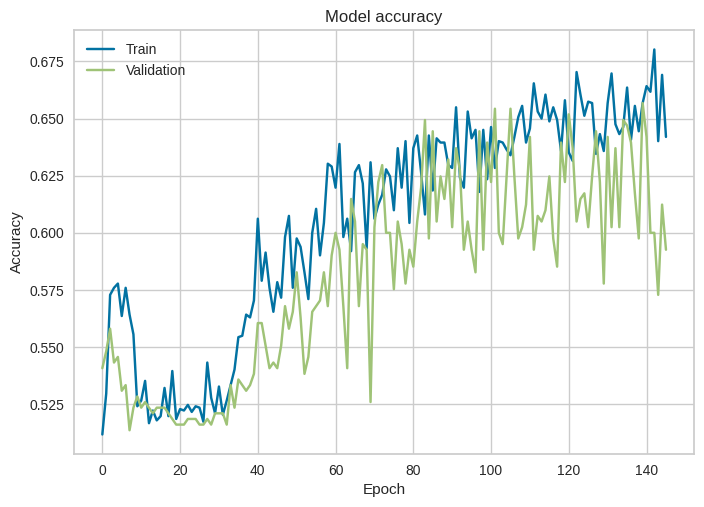

In [ ]:
# 3_Model architecture ---------------------------------
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, n_features, n_classes, label_encoder = preprocess_trainingdata(df2, label_column = 'label', test_size=0.2, random_state=42)
set_seed(42)
model2 = Sequential()
model2.add(Dense(64, activation='leaky_relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.015)))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.175)))
model2.add(Dropout(0.75))
model2.add(Dense(1, activation='sigmoid'))  # Only one neuron for binary classification

# Compile the model
learning_rate = 0.001  # Adjusted learning rate for stability
adam_optimizer = Adam(learning_rate=learning_rate)
model2.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Train the model with EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Define the class weights according to the result
class_weights = {0: 1.25,
                 1: 1}

# Train the model with the new callback/ class weights
history2 = model2.fit(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=500, batch_size=64,
                    callbacks=[es],
                    class_weight=class_weights)

# Save model and training history
model2.save('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model2.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model2_history.pkl', 'wb') as file:
    pickle.dump(history2, file)



Test accuracy: 0.6608186960220337


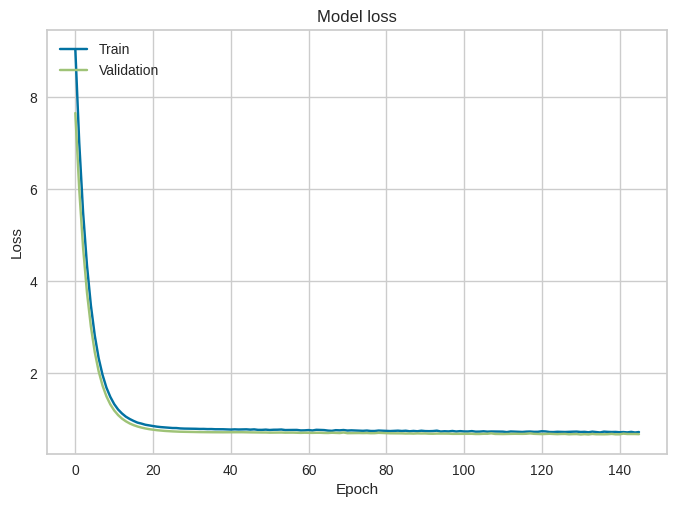

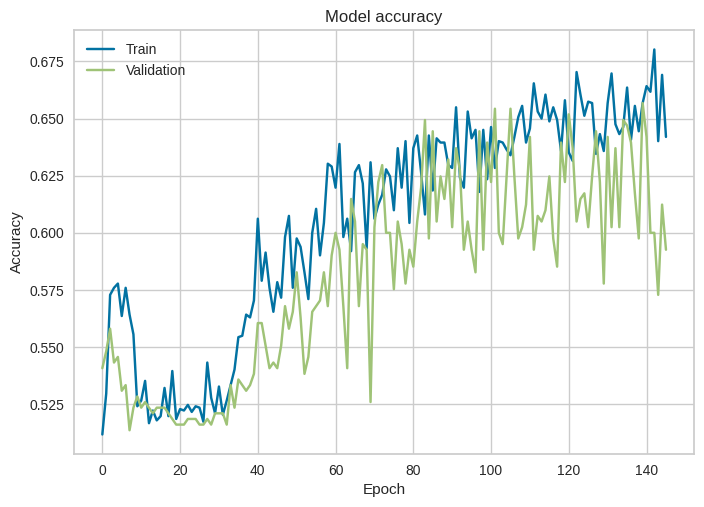

17/17 [==============================] - 0s 2ms/step
Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64       245
           1       0.67      0.69      0.68       268

    accuracy                           0.66       513
   macro avg       0.66      0.66      0.66       513
weighted avg       0.66      0.66      0.66       513



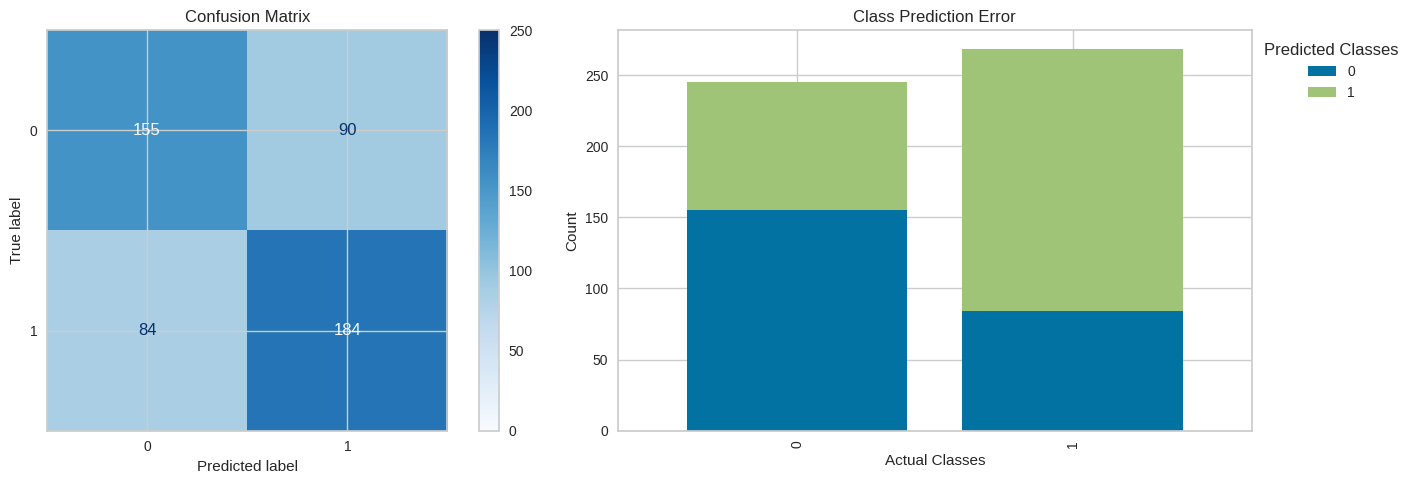

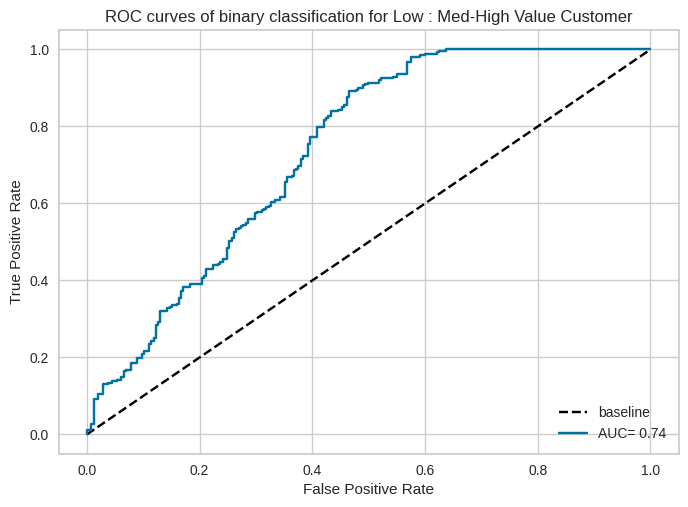

In [22]:
# 4_Model Evaluation ------------------------------------------
# Load the saved model
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model2.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model2_history.pkl', 'rb') as file:
    history2 = pickle.load(file)
# Call function for evaluating model training
evaluate_and_plot_model(model2, X_test_scaled, y_test_encoded, history2)

# Predict on the test set and threshold probabilities
y_pred_prob_dl = model2.predict(X_test_scaled)
y_pred = (y_pred_prob_dl > 0.5).astype(int)
y_pred = y_pred.ravel()

# Call funtion for classification report
display_classification_results(y_test_encoded, y_pred, label_encoder)
plot_binaryclass_roc(y_test_encoded, y_pred_prob_dl, title='ROC curves of binary classification for Low : Med-High Value Customer')


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from joblib import dump, load


###- DecisionTreeClassifier

In [ ]:
# Model2/1_DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'max_depth': [None, 5, 10, 15, 20, 25, 50],
    'min_samples_split': stats.randint(1, 25),
    'min_samples_leaf': stats.randint(1, 10)
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=50, random_state=42)

# Fit the model
random_search.fit(X_train_scaled, y_train_encoded)

# Get the best estimator from the random search
best_tree = random_search.best_estimator_
dump(best_tree, '/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/decision_tree_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/decision_tree_model.joblib']

DecisionTreeClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=23,
                       random_state=42)
Best Decision Tree: 

Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.51      0.53       245
           1       0.57      0.61      0.59       262

    accuracy                           0.56       507
   macro avg       0.56      0.56      0.56       507
weighted avg       0.56      0.56      0.56       507



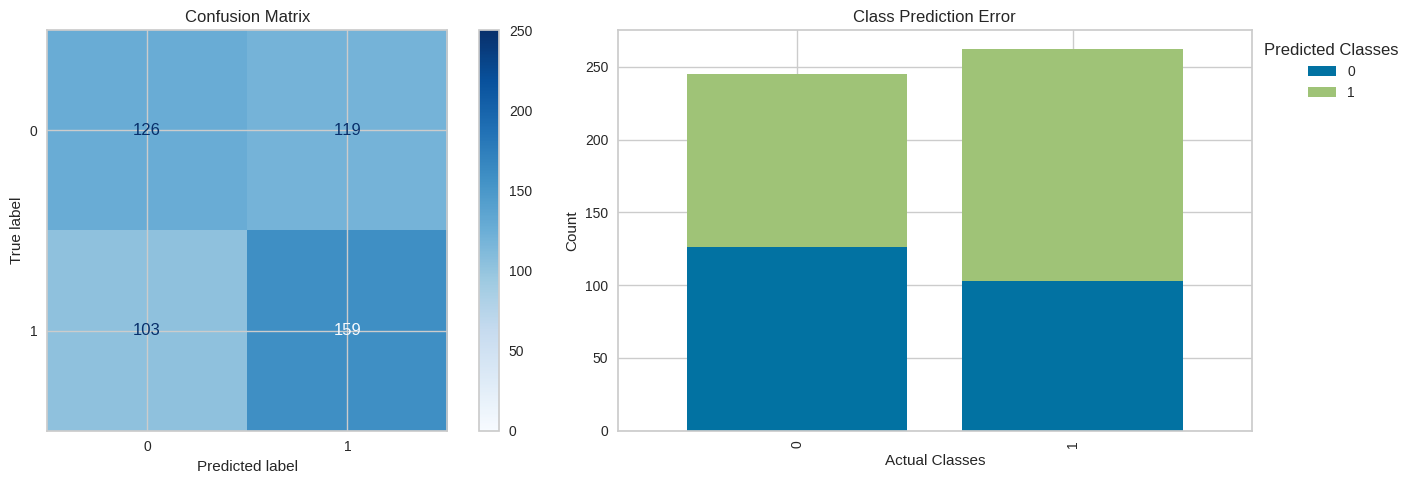

In [ ]:
best_tree = load('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/decision_tree_model.joblib')
# Predict on the test set
y_pred_prob_tree = best_tree.predict(X_test_scaled)
# Predict on the test set and threshold probabilities
y_pred = (y_pred_prob_tree > 0.5).astype(int)
y_pred = y_pred.ravel()

# Calculate and print classification report
print(best_tree)
print("Best Decision Tree: \n")
# Call funtion for classification report
display_classification_results(y_test_encoded, y_pred, label_encoder)

###- KNeighborsClassifier

KNeighborsClassifier(n_neighbors=7)
Best KNeighborsClassifier with RandomizedSearch: 

Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59       245
           1       0.62      0.71      0.66       262

    accuracy                           0.63       507
   macro avg       0.63      0.63      0.63       507
weighted avg       0.63      0.63      0.63       507



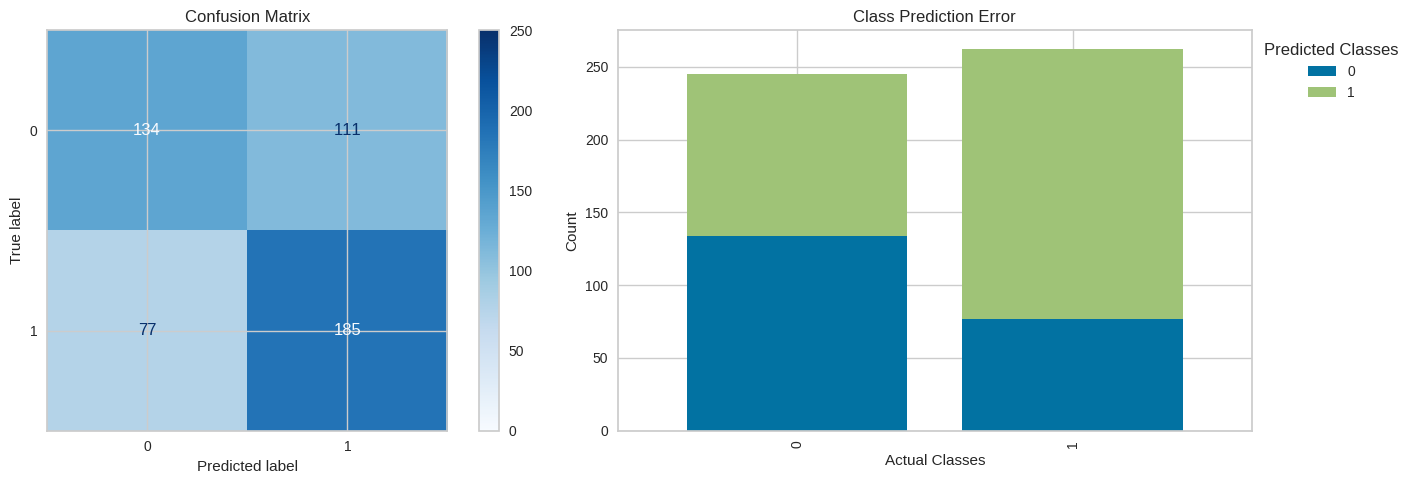

In [ ]:
# Model2_KNeighbors
knc = KNeighborsClassifier()
param_dist = {
    'n_neighbors': stats.randint(1, 21),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(knc, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=50, random_state=42)

# Fit the model
random_search.fit(X_train_scaled, y_train_encoded)

# Get the best estimator from the random search
best_knc = random_search.best_estimator_
dump(best_knc, '/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/knc_model.joblib')

# Predict on the test set
best_knc = load('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/knc_model.joblib')
y_pred_prob_knc = best_knc.predict(X_test_scaled)
# Predict on the test set and threshold probabilities
y_pred = (y_pred_prob_knc > 0.5).astype(int)
y_pred = y_pred.ravel()

# Calculate and print classification report
print(best_knc)
print("Best KNeighborsClassifier with RandomizedSearch: \n")
display_classification_results(y_test_encoded, y_pred, label_encoder)

### - Ensemble Voting Classifier
combines  different  learning classifiers and uses a majority vote or the average predicted probabilities (soft vote) to predict the class labels using Logistic Regression, Random Forest, and Support Vector Classifier (SVC)

In [ ]:
''' 3
ensemble voting classifier: Logistic Regression, Random Forest, and Support Vector Classifier (SVC)
combines  different  learning classifiers and uses a majority vote or the average predicted probabilities (soft vote) to predict the class labels.
'''

steps = [('scaler', StandardScaler()),
         ('pca', PCA())]

preprocess = Pipeline(steps)

# Preprocessing the data
X_train_preprocessed = preprocess.fit_transform(X_train_scaled)
X_test_preprocessed = preprocess.transform(X_test_scaled)

# Defining the classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Voting Classifier with soft voting
eclf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')


# Parameters for tuning the classifiers
params =  {
    'lr__C': uniform(0.01, 100),
    'rf__n_estimators': sp_randint(10, 200),
    #'rf__max_depth': [None] + list(range(10, 51, 10)),
    'svc__C': uniform(0.01, 100),
    #'svc__kernel': ['rbf', 'poly', 'sigmoid']
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=eclf,
                                   param_distributions=params,
                                   n_iter=50,
                                   cv=10,
                                   random_state=42)

# Fitting the model
random_search.fit(X_train_preprocessed, y_train_encoded)

# Get the best estimator from the random search
best_vote = random_search.best_estimator_
dump(best_vote, '/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/VotingClassifier_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/VotingClassifier_model.joblib']

Best Ensemble Voting Classifier with GRidSearch: 

Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61       245
           1       0.63      0.61      0.62       262

    accuracy                           0.62       507
   macro avg       0.62      0.62      0.62       507
weighted avg       0.62      0.62      0.62       507



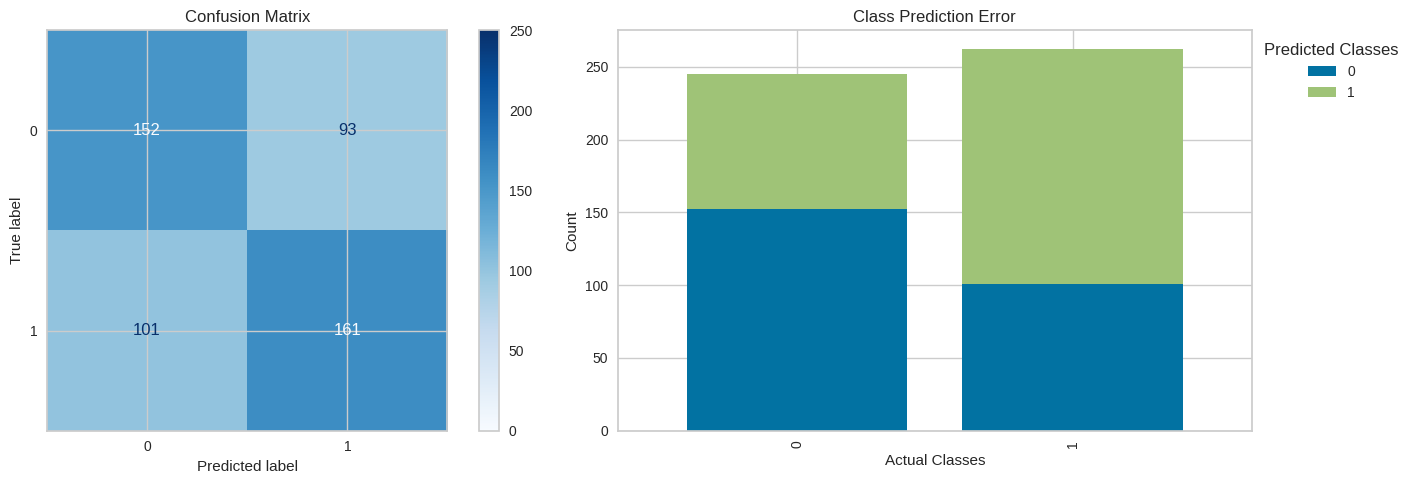

In [ ]:
# Predict on the test set
best_vote = load('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/VotingClassifier_model.joblib')

y_pred_prob_vote = best_vote.predict_proba(X_test_preprocessed)[:, 1]
# Predict on the test set and threshold probabilities
y_pred = (y_pred_prob_vote > 0.575).astype(int)

# Calculate and print classification report
print("Best Ensemble Voting Classifier with GRidSearch: \n")
display_classification_results(y_test_encoded, y_pred, label_encoder)

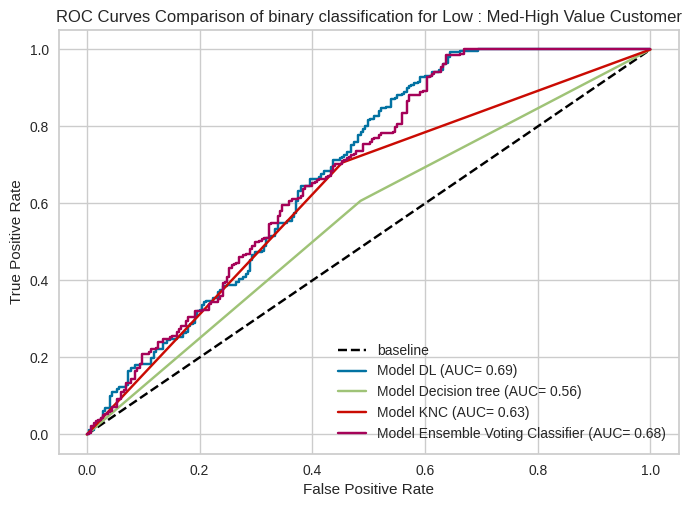

In [ ]:
model_pred_probs = {
    'Model DL': y_pred_prob_dl.ravel(),
    'Model Decision tree': y_pred_prob_tree,
    'Model KNC' : y_pred_prob_knc,
    'Model Ensemble Voting Classifier' :y_pred_prob_vote
 }
plot_multiple_roc_curves(y_test_encoded, model_pred_probs, title='ROC Curves Comparison of binary classification for Low : Med-High Value Customer')

### Conclusion:
- Task II: Binary classification Model :High-Value Customer Identification between low-v alue customer (0)/ med/ high-v alue customer (1)
- Model: deep learning model/ decision tree/ KNN/ Ensemble voting classification
- Result: The deep learning model outperformed baseline and others with an AUC score of 0.69. We will utilize this trained two-stage model to classify new customer dataset on the next stage.




#4.0 Appendix

In [ ]:
# Use Keras-Tuner for finding initial of the best hyperparameter
# Function to return the appropriate activation layer
def get_activation_layer(name):
    if name == 'leaky_relu':
        return LeakyReLU()
    elif name == 'elu':
        return ELU()
    else:
        return relu

def build_model(hp):
    model = Sequential()
    # Choice of activation function
    activation_choice = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])

    # 1st layer
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=25),
                    activation=get_activation_layer(activation_choice),
                    input_shape=(n_features,),
                    kernel_regularizer=regularizers.l1(hp.Choice('reg_1', values=[0.01, 0.1, .25, .5]))))
    model .add(Dropout(hp.Float('dropout_1', min_value=0.01, max_value=0.7, step=0.1)))

    # 2nd layer
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=25),
                    activation=get_activation_layer(activation_choice),
                    kernel_regularizer=regularizers.l1(hp.Choice('reg_2', values=[0.01, 0.1, .25, .5]))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.01, max_value=0.7, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Choice of optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    # Learning rate (if applicable)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Selecting the optimizer
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10, directory='keras_tuner_dir', project_name='keras_tuner_model3_1'
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
tuner.search(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=100, callbacks=[es])

# Get the best hyperparameters.
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Get the best hyperparameters.
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values
# Build the model with the best hp.
model3 = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.5308310985565186

Best val_accuracy So Far: 0.5844504237174988
Total elapsed time: 00h 01m 55s
